**Logistic Regression Model for Predicting Bad Hydrophone Channels**

The scope of this project is to properly model and train an algorithm that is able to identify bad receivers.

The data contains different receiver statistics which include some instrumentational feedback (capacitance, leakage, sensitivity, etc..) decoded from original SEGD field data. There is also some computed statistics such as, root mean square of (noise) amplitude, standard deviation of RMS, etc.., which would traditionally be used to "pick bad channels") and also some user defined target variable (identified bad receivers).

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.ticker as ticker
from sklearn import preprocessing

List files in directory to use:

In [2]:
import sys, os
print(os.listdir())

['.git', '001_amp_maps_2890.csv', '002_amp_maps_3422.csv', '003_amp_maps_2918.csv', '004_amp_maps_3450.csv', '005_amp_maps_2946.csv', '006_amp_maps_3478.csv', '008_P_amp_maps_2265P01.csv', 'Bad_Channels.ipynb', 'Bad_Channels_Logistic_Regression.ipynb', 'decode_listing_features_001.csv', 'decode_listing_features_002.csv', 'decode_listing_features_003.csv', 'decode_listing_features_003_old.csv', 'decode_listing_features_004.csv', 'decode_listing_features_005.csv', 'decode_listing_features_006.csv', 'decode_listing_features_010_old.csv', 'Log_ROC.png', 'README.md', 'RMS.png']


Now we import the first set of data, which include have some sequence specific features, including the target feature "BAD_CHAN_FLAG" (binary, 0 good, 1 bad).

In [7]:
stats1=pd.read_csv('decode_listing_features_001.csv')
stats1['SEQ']=1
#stats1a=pd.read_csv('decode_listing_features_002.csv')
#stats1a['SEQ']=2
#stats1b=pd.read_csv('decode_listing_features_003.csv')
#stats1b['SEQ']=3
#stats1c=pd.read_csv('decode_listing_features_004.csv')
#stats1c['SEQ']=4
#stats1d=pd.read_csv('decode_listing_features_005.csv')
#stats1d['SEQ']=5
#stats1e=pd.read_csv('decode_listing_features_005.csv')
#stats1e['SEQ']=6
#stats1=stats1.append(stats1a)
#stats1=stats1.append(stats1b)
#stats1=stats1.append(stats1c)
#stats1=stats1.append(stats1d)
#stats1=stats1.append(stats1e)

In [8]:
stats1.head()

,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,CHANNEL,DEEP_RMS,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS,SEQ
0,0,0,0,232.691345,1,10.58,4,0,5.0,0,31.66,1
1,0,0,0,228.366440,2,7.28,0,0,5.0,0,31.22,1
2,0,0,0,234.802597,3,6.10,0,0,5.0,0,30.32,1
3,0,0,0,233.590988,4,6.78,0,0,5.0,0,31.26,1
4,0,0,0,228.584885,5,7.02,0,0,5.0,0,31.13,1


Now we import the RMS (noise) amplitude maps that will be used to derive more statistics. These provide an overview of recorded noise on the streamers - both backround and in our case when individual components breakdown and show up as bad channels.

In [5]:
stats2=pd.read_csv('001_amp_maps_2890.csv')
stats2['SEQ']=1
#stats2=pd.read_csv('008_P_amp_maps_2265P01.csv')
#stats2['SEQ']=1
#stats2a=pd.read_csv('002_amp_maps_3422.csv')
#stats2a['SEQ']=2
#stats2b=pd.read_csv('003_amp_maps_2918.csv')
#stats2b['SEQ']=3
#stats2c=pd.read_csv('004_amp_maps_3450.csv')
#stats2c['SEQ']=4
#stats2d=pd.read_csv('005_amp_maps_2946.csv')
#stats2d['SEQ']=5
#stats2e=pd.read_csv('006_amp_maps_3478.csv')#
#stats2e['SEQ']=6

Due to large file size only run more than one sequence and the following append code block if the computer has enough RAM.

In [ ]:
#stats2=stats2.append(stats2a)
#stats2=stats2.append(stats2b)
#stats2=stats2.append(stats2c)
#stats2=stats2.append(stats2d)
#stats2=stats2.append(stats2e)

In [6]:
stats2.head()

,SRC_POINT,CHANNEL,WC_RMS,TGT_RMS,DEEP_RMS,FFID,CABLE,CABTR,SEQ
0,5071,1,5.415281,30.081125,12.606074,1001,1,1,1
1,5071,2,6.816298,28.298389,9.360264,1001,1,2,1
2,5071,3,6.319650,25.300581,8.873336,1001,1,3,1
3,5071,4,2.712788,28.077599,7.638037,1001,1,4,1
4,5071,5,4.047064,27.413845,9.036798,1001,1,5,1


Get standard deviation of root mean squared values, grouped by sequence and receiver number.

In [9]:
std_=stats2.groupby(['SEQ','CHANNEL'])['DEEP_RMS'].agg(np.std)

In [10]:
std_=pd.DataFrame(std_)

In [11]:
std_.sort_values(['SEQ','CHANNEL'],inplace=True)
stats1.sort_values(['SEQ','CHANNEL'],inplace=True)

In [12]:
std_.reset_index(inplace=True)
len(std_)

9072

In [13]:
len(stats1)

9072

In [14]:
std_.head()

,SEQ,CHANNEL,DEEP_RMS
0,1,1,3.725214
1,1,2,2.094594
2,1,3,1.885017
3,1,4,2.093174
4,1,5,2.046160


Merge the two dataframes.

In [15]:
df1=pd.merge(std_,stats1 , how='left', left_on=['SEQ','CHANNEL'], right_on=['SEQ','CHANNEL'])
df2=df1.copy()

In [16]:
df2.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,1,1,3.725214,0,0,0,232.691345,10.58,4,0,5.0,0,31.66
1,1,2,2.094594,0,0,0,228.366440,7.28,0,0,5.0,0,31.22
2,1,3,1.885017,0,0,0,234.802597,6.10,0,0,5.0,0,30.32
3,1,4,2.093174,0,0,0,233.590988,6.78,0,0,5.0,0,31.26
4,1,5,2.046160,0,0,0,228.584885,7.02,0,0,5.0,0,31.13
5,1,6,1.960650,0,0,0,230.264236,6.56,0,0,5.0,0,30.82
6,1,7,2.006694,0,0,0,230.004303,6.84,0,0,5.0,0,31.01
7,1,8,2.026388,0,0,0,231.898392,6.79,0,0,5.0,0,31.13
8,1,9,1.988935,0,0,0,230.703339,7.01,0,0,5.0,0,30.98
9,1,10,2.097428,0,0,0,226.584427,7.53,0,0,5.0,0,31.27


Plot the Root Mean Square (RMS) of (noise) Amplitudes

In [17]:
a=stats2['TGT_RMS']

In [18]:
b=a.to_list()

Re-shape the list for plotting.

In [19]:
c=np.reshape(b,(-1,9072))
c=np.transpose(c)

A little clipping of the value to 100 for color scaling.

In [20]:
c=np.clip(c,0,100)

In [21]:
%matplotlib inline

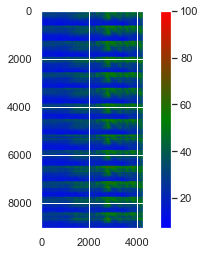

In [22]:
import matplotlib.colors as colly

cmap1= colly.LinearSegmentedColormap.from_list("" , ['blue','green','red'])

im=plt.imshow(c, cmap=cmap1)
plt.colorbar(im)
plt.rcParams["figure.figsize"] = (70,20)
plt.savefig('RMS.png')

plt.show()

**Now for the modelling part...**

In [23]:
df1.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,1,1,3.725214,0,0,0,232.691345,10.58,4,0,5.0,0,31.66
1,1,2,2.094594,0,0,0,228.366440,7.28,0,0,5.0,0,31.22
2,1,3,1.885017,0,0,0,234.802597,6.10,0,0,5.0,0,30.32
3,1,4,2.093174,0,0,0,233.590988,6.78,0,0,5.0,0,31.26
4,1,5,2.046160,0,0,0,228.584885,7.02,0,0,5.0,0,31.13
5,1,6,1.960650,0,0,0,230.264236,6.56,0,0,5.0,0,30.82
6,1,7,2.006694,0,0,0,230.004303,6.84,0,0,5.0,0,31.01
7,1,8,2.026388,0,0,0,231.898392,6.79,0,0,5.0,0,31.13
8,1,9,1.988935,0,0,0,230.703339,7.01,0,0,5.0,0,30.98
9,1,10,2.097428,0,0,0,226.584427,7.53,0,0,5.0,0,31.27


Drop one by one the features we do not need...

In [25]:
df1=df1.drop('CAP_CUT_ERR',1)
df1=df1.drop('CAP_ERR',1)
df1=df1.drop('LEAK_ERR',1)
df1=df1.drop('SENS',1)
df1=df1.drop('MARG_CHAN_FLAG',1)

C:\Users\sirproc\AppData\Local\Temp\ipykernel_16856\1774694302.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('CAP_CUT_ERR',1)
C:\Users\sirproc\AppData\Local\Temp\ipykernel_16856\1774694302.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('CAP_ERR',1)
C:\Users\sirproc\AppData\Local\Temp\ipykernel_16856\1774694302.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('LEAK_ERR',1)
C:\Users\sirproc\AppData\Local\Temp\ipykernel_16856\1774694302.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1=df1.drop('SENS',1)
C:\Users\sirproc\AppData\Local\Temp\ipykernel_16856\1774694302.py:5: FutureWarning

In [24]:
df1.head()

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,1,1,3.725214,0,0,0,232.691345,10.58,4,0,5.0,0,31.66
1,1,2,2.094594,0,0,0,228.366440,7.28,0,0,5.0,0,31.22
2,1,3,1.885017,0,0,0,234.802597,6.10,0,0,5.0,0,30.32
3,1,4,2.093174,0,0,0,233.590988,6.78,0,0,5.0,0,31.26
4,1,5,2.046160,0,0,0,228.584885,7.02,0,0,5.0,0,31.13


In [25]:
pd.to_numeric(df1['BAD_CHAN_FLAG'])
y=pd.DataFrame(df1['BAD_CHAN_FLAG'])
X=df1.drop(['BAD_CHAN_FLAG'],1)

C:\Users\sirproc\AppData\Local\Temp\ipykernel_12412\1240260745.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df1.drop(['BAD_CHAN_FLAG'],1)


In [26]:
yy=y.values.tolist()

In [27]:
X2=X.copy()
X2=X2.drop(['CHANNEL','SEQ'],1)

C:\Users\sirproc\AppData\Local\Temp\ipykernel_12412\447026479.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2=X2.drop(['CHANNEL','SEQ'],1)


In [28]:
# Calculate the correlation values
feature_cols = X2.columns
corr_values = X2[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

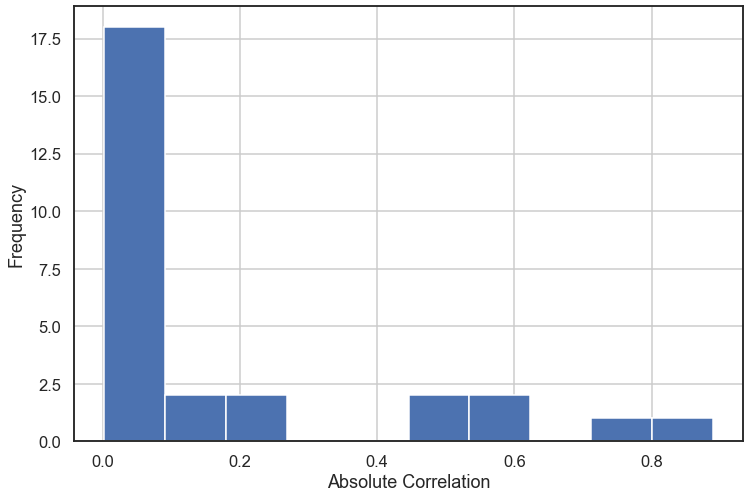

In [29]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=10, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [30]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.2')

,feature1,feature2,correlation,abs_correlation
17,DEEP_RMS_y,SENS,0.723199,0.723199
6,DEEP_RMS_x,SENS,0.562433,0.562433
1,DEEP_RMS_x,DEEP_RMS_y,0.554213,0.554213
23,LEAK_ERR,MARG_CHAN_FLAG,0.485388,0.485388
13,DEEP_RMS_y,DEVICE,0.253006,0.253006
25,LEAK_VAL,MARG_CHAN_FLAG,-0.450038,0.450038
22,LEAK_ERR,LEAK_VAL,-0.889073,0.889073


**Logistic Regression**

In [31]:
XX=X2.values.tolist()

In [32]:
XX[0:5]

[[3.725214248963877, 0.0, 0.0, 232.691345, 10.58, 4.0, 0.0, 5.0, 0.0, 31.66],
 [2.0945937529968033, 0.0, 0.0, 228.36644, 7.28, 0.0, 0.0, 5.0, 0.0, 31.22],
 [1.8850165095194575, 0.0, 0.0, 234.802597, 6.1, 0.0, 0.0, 5.0, 0.0, 30.32],
 [2.0931738147193406, 0.0, 0.0, 233.590988, 6.78, 0.0, 0.0, 5.0, 0.0, 31.26],
 [2.0461598423613534, 0.0, 0.0, 228.584885, 7.02, 0.0, 0.0, 5.0, 0.0, 31.13]]

We use a standard scalar to normalise the dataset.

In [33]:
XX=preprocessing.StandardScaler().fit(XX).transform(XX)

In [34]:
XX[0:5]

array([[ 3.28383591e+00,  0.00000000e+00,  0.00000000e+00,
        -9.74047382e-02,  2.43199616e+00,  2.87776781e+00,
        -5.15026203e-02,  6.34679145e-02, -1.06106077e-01,
         9.91887362e-01],
       [ 5.46978559e-01,  0.00000000e+00,  0.00000000e+00,
        -5.63734644e-01,  3.87188179e-01, -2.90955285e-01,
        -5.15026203e-02,  6.34679145e-02, -1.06106077e-01,
         8.59420139e-01],
       [ 1.95221041e-01,  0.00000000e+00,  0.00000000e+00,
         1.30239556e-01, -3.43985586e-01, -2.90955285e-01,
        -5.15026203e-02,  6.34679145e-02, -1.06106077e-01,
         5.88464454e-01],
       [ 5.44595314e-01,  0.00000000e+00,  0.00000000e+00,
        -4.01350614e-04,  7.73687870e-02, -2.90955285e-01,
        -5.15026203e-02,  6.34679145e-02, -1.06106077e-01,
         8.71462614e-01],
       [ 4.65686374e-01,  0.00000000e+00,  0.00000000e+00,
        -5.40180963e-01,  2.26082095e-01, -2.90955285e-01,
        -5.15026203e-02,  6.34679145e-02, -1.06106077e-01,
         8.

Test the logistic regression on the whole dataset.

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(yy,XX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.692296
         Iterations 4


LinAlgError: Singular matrix

We now split the data to see how it perform with the train/test.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.5, random_state=0)

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\Users\sirproc\Anaconda3\envs\data_science\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [38]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


Now we examine the Confusion Matrix.

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4504    4]
 [  22    6]]


We now examine some key metrics to see if the model acts properly.

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4508
           1       0.60      0.21      0.32        28

    accuracy                           0.99      4536
   macro avg       0.80      0.61      0.66      4536
weighted avg       0.99      0.99      0.99      4536



Now we look at the Receiver Operating Characteristic (ROC) curve

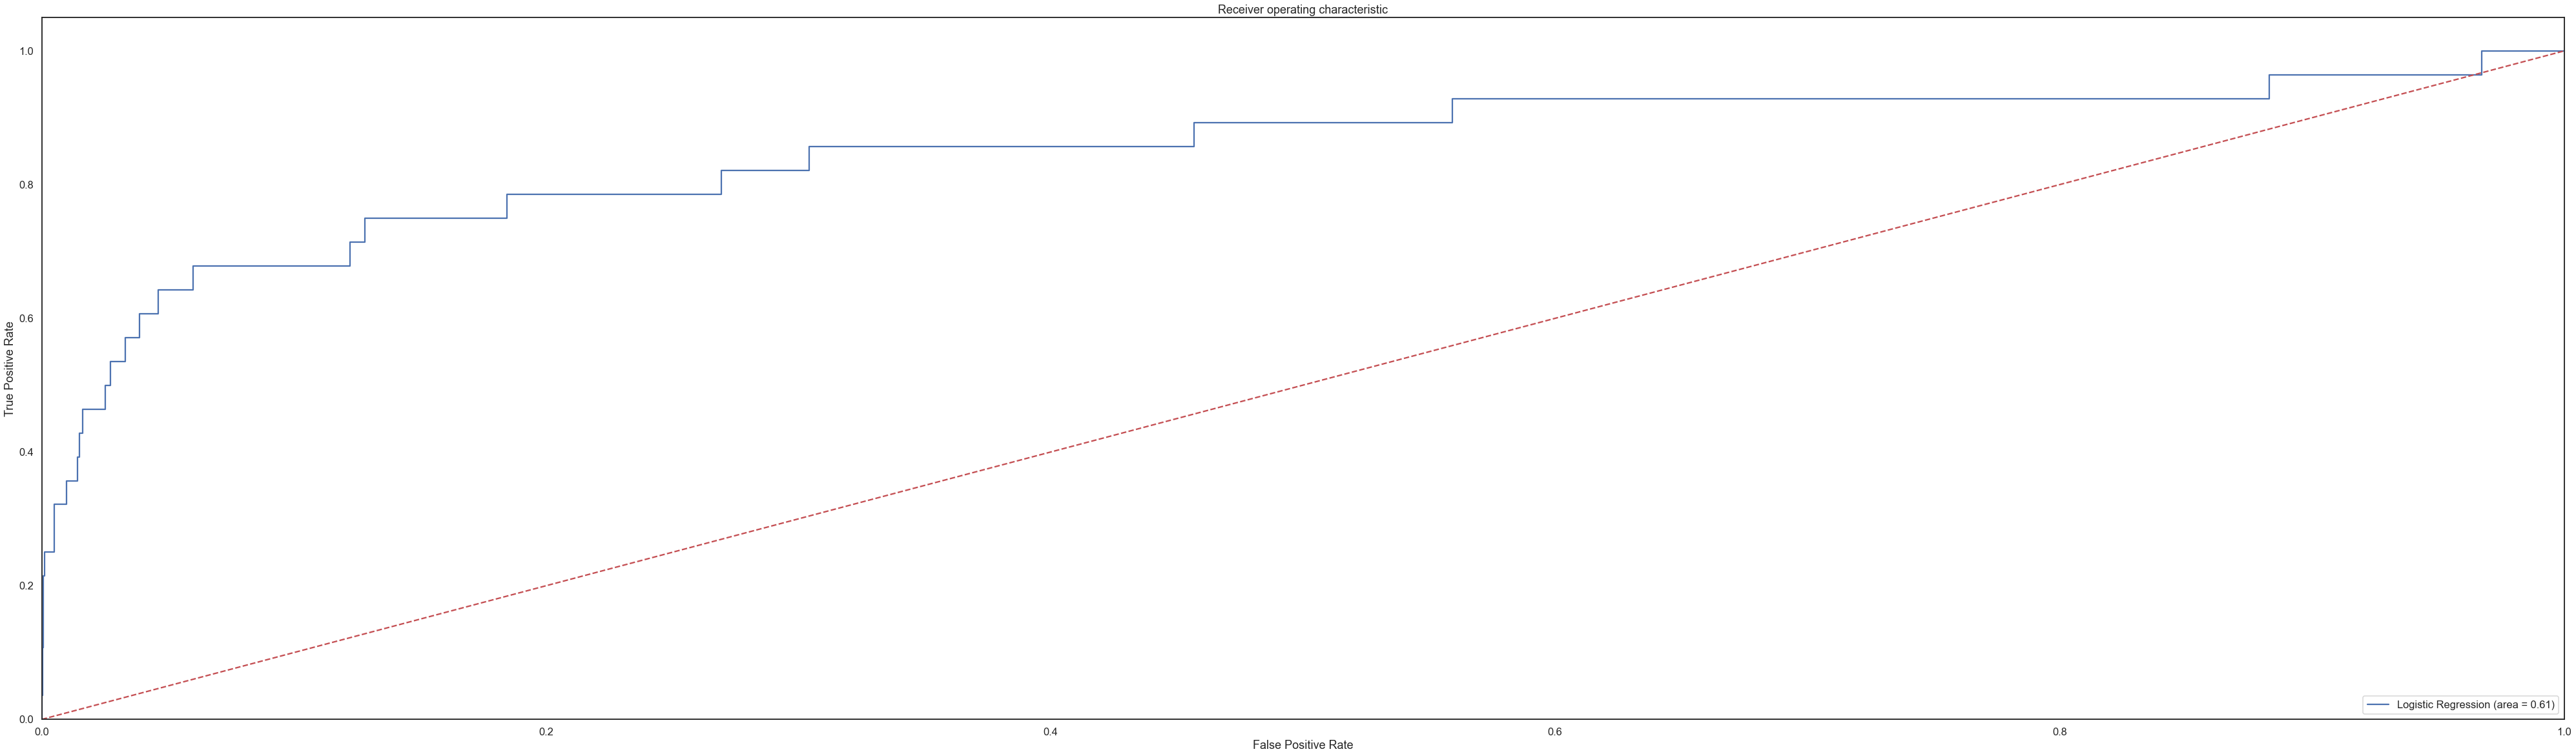

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC.png')
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

Attempting to get the sequence and channel back to a dataframe.

In [43]:
fd=pd.DataFrame(y_pred)
fd2=pd.DataFrame(y_test)

In [44]:
fd2.head()

,0
0,0
1,0
2,0
3,0
4,0


In [45]:
FD2=fd2.reset_index()
FD2.set_axis(['index','FLAG_ORIG'],axis=1,inplace=True)

In [46]:
merge=FD2.merge(fd,left_index=True, right_index=True)
merge.set_axis(['index','FLAG_ORIG','PREDICT'],axis=1,inplace=True)

In [47]:
merge.head()

,index,FLAG_ORIG,PREDICT
0,0,0,0
1,1,0,0
2,2,0,1
3,3,0,0
4,4,0,0


We create a header to spot the different predictions.

In [48]:
merge['DIFF']=merge['FLAG_ORIG']-merge['PREDICT']

In [49]:
finder=merge['DIFF']!=0
finder

0       False
1       False
2        True
3       False
4       False
        ...  
4531    False
4532    False
4533    False
4534    False
4535    False
Name: DIFF, Length: 4536, dtype: bool

We check what has been predicted different from the test data.

In [50]:
for i,x in merge.iterrows():
    if x['DIFF']!=0:
        print(x)

index        2
FLAG_ORIG    0
PREDICT      1
DIFF        -1
Name: 2, dtype: int64
index        386
FLAG_ORIG      1
PREDICT        0
DIFF           1
Name: 386, dtype: int64
index        490
FLAG_ORIG      0
PREDICT        1
DIFF          -1
Name: 490, dtype: int64
index        546
FLAG_ORIG      1
PREDICT        0
DIFF           1
Name: 546, dtype: int64
index        644
FLAG_ORIG      1
PREDICT        0
DIFF           1
Name: 644, dtype: int64
index        705
FLAG_ORIG      1
PREDICT        0
DIFF           1
Name: 705, dtype: int64
index        1213
FLAG_ORIG       1
PREDICT         0
DIFF            1
Name: 1213, dtype: int64
index        1309
FLAG_ORIG       1
PREDICT         0
DIFF            1
Name: 1309, dtype: int64
index        1405
FLAG_ORIG       1
PREDICT         0
DIFF            1
Name: 1405, dtype: int64
index        1453
FLAG_ORIG       1
PREDICT         0
DIFF            1
Name: 1453, dtype: int64
index        1483
FLAG_ORIG       1
PREDICT         0
DIFF            

In [51]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df1, df1, test_size=0.5, random_state=0)

In [52]:
FD3=y1_test.reset_index()
newtest=pd.merge(FD3,merge)

In [53]:
newtest.head()

,index,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,DEVICE,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS,FLAG_ORIG,PREDICT,DIFF
0,247,1,248,2.415203,0,0,0,244.630630,8.29,0,0,5.0,0,31.94,0,0,0
1,1972,1,1973,1.955668,0,0,0,232.870605,7.63,0,0,5.0,0,32.48,0,0,0
2,1829,1,1830,0.956624,0,0,0,232.227005,4.51,0,0,5.0,0,22.92,0,0,0
3,154,1,155,1.543170,0,0,0,242.414124,5.47,0,0,5.0,0,30.08,0,0,0
4,1278,1,1279,0.922203,0,0,0,236.883118,3.54,0,0,5.0,0,22.35,0,0,0


In [54]:
for i,x in newtest.iterrows():
    if x['PREDICT']>x['BAD_CHAN_FLAG']:
        print(x)

index             4393.000000
SEQ                  1.000000
CHANNEL           4394.000000
DEEP_RMS_x           1.446176
BAD_CHAN_FLAG        0.000000
CAP_CUT_ERR          0.000000
CAP_ERR              0.000000
CAP_VAL            226.530472
DEEP_RMS_y           5.140000
DEVICE               0.000000
LEAK_ERR             0.000000
LEAK_VAL             5.000000
MARG_CHAN_FLAG       0.000000
SENS                23.550000
FLAG_ORIG            0.000000
PREDICT              1.000000
DIFF                -1.000000
Name: 86, dtype: float64
index             2272.000000
SEQ                  1.000000
CHANNEL           2273.000000
DEEP_RMS_x           2.109680
BAD_CHAN_FLAG        0.000000
CAP_CUT_ERR          0.000000
CAP_ERR              0.000000
CAP_VAL            247.254501
DEEP_RMS_y           9.840000
DEVICE               0.000000
LEAK_ERR             0.000000
LEAK_VAL             5.000000
MARG_CHAN_FLAG       0.000000
SENS                31.780000
FLAG_ORIG            1.000000
PREDICT        

Now for comparison we look at a simple lr , lr L1 norm and lr L2 norm Logistic Regression

In [55]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

c:\Users\sirproc\Anaconda3\envs\data_science\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
from sklearn.linear_model import LogisticRegressionCV
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

c:\Users\sirproc\Anaconda3\envs\data_science\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

c:\Users\sirproc\Anaconda3\envs\data_science\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()
coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]
for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0,0,0
1,0,0,0
2,1,0,0
3,0,0,0
4,0,0,0


In [60]:
y_prob.head()

,lr,l1,l2
0,0.996878,0.5,0.980332
1,0.997633,0.5,0.985511
2,0.508511,0.5,0.783742
3,0.996893,0.5,0.979379
4,0.998146,0.5,0.985073


In [61]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:
    
    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted'
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
#   auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
#       label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
#       average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                                'fscore':fscore, 'accuracy':accuracy},
#                                   auc':auc},
                                name=lab))
metrics = pd.concat(metrics, axis=1)

SyntaxError: invalid syntax (3685462447.py, line 10)

Checking the results..

In [62]:
metrics

<module 'sklearn.metrics' from 'c:\\Users\\sirproc\\Anaconda3\\envs\\data_science\\lib\\site-packages\\sklearn\\metrics\\__init__.py'>

Lastly, the three confusion matrices:

NameError: name 'cm' is not defined

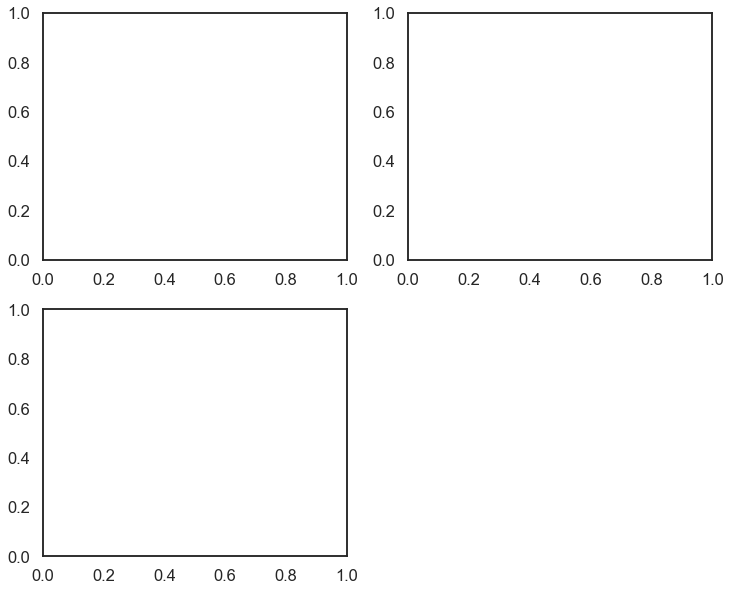

In [63]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d',cmap=cmap1);
    ax.set(title=lab);

plt.tight_layout()

**Conclsions**